<a href="https://colab.research.google.com/github/kapibara3chi/NLPTesForGC/blob/main/NLPTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pip

In [2]:
!pip  install -U ginza ja_ginza_electra
!pip install plantuml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 10.0 MB/s 
     |████████████████████████████████| 2.2 MB 54.6 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 283 kB 55.2 MB/s 
     |████████████████████████████████| 1.2 MB 48.4 MB/s 
     |████████████████████████████████| 5.8 MB 48.5 MB/s 
     |████████████████████████████████| 7.6 MB 52.7 MB/s 
     |████████████████████████████████| 182 kB 63.7 MB/s 
  Created wheel for SudachiDict-core: filename=SudachiDict_core-20221021-py3-none-any.whl size=71574782 sha256=095f511903cf4c79b62a06164c5a55374513b33d82321f4ef25d7a036f963d60
  Stored in directory: /root/.cache/pip/wheels/ca/e3/ed/e78fecf6fd34349114d292242a16fc08d513fb32c2d9c5d786
  Created wheel for sudachitra: filename=SudachiTra-0.1.7-py3-none-any.whl size=266095 sha256=4b60590474be5e30c29f1583565988941106e7c5e8f5ef8b5254b60cec4ba7

# Plant UML

[{'filename': 'sample.puml', 'gen_success': True}]


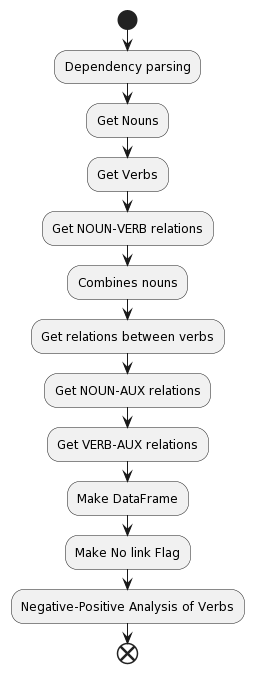

In [3]:
with open('/content/sample.puml', 'w+') as f:
	f.write('''

@startuml
start
:Dependency parsing;
:Get Nouns;
:Get Verbs;
:Get NOUN-VERB relations;
:Combines nouns;
:Get relations between verbs;
:Get NOUN-AUX relations;
:Get VERB-AUX relations;
:Make DataFrame;
:Make No link Flag;
:Negative-Positive Analysis of Verbs;
end
@enduml

''')

!python -m plantuml sample.puml

from IPython.display import Image

Image('sample.png')

# Code

In [5]:
import ginza
from spacy import displacy
import spacy
import sys
import pandas as pd
class DependencyAnalysis:
    def __init__(self):
        self.nlp = spacy.load('ja_ginza_electra')
        self.indices = []
        self.noun_l=[]
        self.verb_l=[]
        self.noun_verb_relation_l=[]
        self.merged_cnoun_l=[]
        self.sent_cnt=0
        cols = ["sent_cnt","i", "orth", "base","head","dep","pos","tag"]
        # self.dependent_indecies_pd = pd.DataFrame(index=[], columns=cols)
        self.depend_indecies_pd = pd.DataFrame( columns=cols)

    def get_analysis(self, text):
        """係り受け解析"""
        doc = self.nlp(text)

        token_head_list = []

        for sent in doc.sents:
            for token in sent:
                token_head_list.append(
                    {"i": token.i, "orth": token.orth_, "base": token.lemma_,
                     "head": token.head.i, "dep": token.dep_,"pos":token.pos_,
                     "tag":token.tag_})
                df_tmp=pd.DataFrame({"sent_cnt":self.sent_cnt,"i": [token.i], 
                                     "orth": [token.orth_], "base":[token.lemma_],
                                     "head":[token.head.i], "dep": [token.dep_],
                                     "pos":[token.pos_], "tag":[token.tag_]})
                self.depend_indecies_pd= pd.concat([self.depend_indecies_pd, df_tmp])

        displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})
        print(self.depend_indecies_pd)

        return token_head_list
    # def get(self, text, target):
    #   # 係り受け解析
    #   self.depend_indices = self.get_analysis(text)
    #   print(self.depend_indices)

    def get_words(self,  m, head):
        """対象の領域の抽出"""
        
        if m["head"] == head :
            for n in self.depend_indices:
                self.get_words(m=n, head=m["i"])
                            
            self.indices.append(m["i"])
        
        return
    def get(self, text, target):
        
        # 係り受け解析
        self.depend_indices = self.get_analysis(text)
        # print(self.depend_indices)
        for i in self.depend_indices:
          print(i)
                
        # 係り元のインデックスを取得
        head = self.depend_indices[target]["head"]
        # print(head)

        # 係り元のかかり先を探索
        self.indices.append(head)
        print(self.indices)#list of head?
        for m in self.depend_indices:
            if m["head"] == head and m["dep"] != "ROOT":
                self.get_words(m, head=head)

        clause = ""
        for clause_num in sorted(self.indices):
            clause = clause + str(self.depend_indices[clause_num]["orth"])
            
        return clause



    def get_noun(self):
      # print(type(self.depend_indices))
      # noun_l=[i for i in self.depend_indices if "名詞" in i["tag"]]

      ex_l=["こと"]
      noun_l=[i for i in self.depend_indices if "NOUN" in i["pos"] or "PROPN" in i["pos"] or "NUM" in i["pos"]or "SYM" in i["pos"]]
      noun_l=[i for i in noun_l if not i["base"] in ex_l]

      self.noun_df=self.depend_indecies_pd[(self.depend_indecies_pd["pos"]=="NOUN") | (self.depend_indecies_pd["pos"]=="PROPN")| (self.depend_indecies_pd["pos"]=="NUM")| (self.depend_indecies_pd["pos"]=="SYM") ]
      for i in ex_l:
        self.noun_df=self.noun_df[self.noun_df["base"]!=i]

      # print(self.noun_df)
      return noun_l
   
    def get_verb(self):
      verb_l=[i for i in self.depend_indices if "VERB" in i["pos"]]
      ex_l=["する","おく"]
      verb_l=[i for i in verb_l if not i["base"] in ex_l]
      # print(verb_l)

      self.verb_df=self.depend_indecies_pd[self.depend_indecies_pd["pos"]=="VERB"]
      for i in ex_l:
        self.verb_df=self.verb_df[self.verb_df["base"]!=i]
      # print(self.verb_df)
      return verb_l

    def seek_verb(self,noun): 
      #Find verb from noun
      if noun is None:
        return
      parents_idx=noun["head"]
      if noun["i"]==noun["head"]:
        # print("same index")
        return
      # print(parents_idx)
      if self.depend_indices[parents_idx]["pos"]=="VERB":
        # print("VERB",self.depend_indices[parents_idx])
        return self.depend_indices[parents_idx]
        # print("error")
      elif self.depend_indices[parents_idx]["dep"]=="ROOT":
        print("ROOT END") 
        return
      else:
        # print("loop")
        return self.seek_verb(self.depend_indices[parents_idx])

    def merge_set(self,set_l):
      merged_set_l=[]
      if len(set_l)==1:
        merged_set_l=set_l
        return merged_set_l

      for i in range(len(set_l)):
        itm=set_l.pop(0)
        # print("loop",i)
        # print("list:",set_l)
        # print("i:",i,"pop itm:",itm)
        flag=False
        # print("len(set_l)",len(set_l))
        if len(set_l)==0:
          itm_l=list(itm)
          itm_l.sort()
          merge_word=self.make_compound_word(itm_l)
          merged_set_l.append([itm_l,merge_word])
          # print("len=0 break")
          break
        for idx,j in enumerate(set_l):
          if len(itm & j) !=0:
            mrg=itm | j
            set_l[idx]=mrg
            flag=True
            # print("merge:",mrg)
            break
        if flag==False:
          itm_l=list(itm)
          itm_l.sort()
          merge_word=self.make_compound_word(itm_l)
          merged_set_l.append([itm_l,merge_word])
        # print("merged list:",merged_set_l)
        # print("-"*10)
      # print("="*100)
      # print(merged_set_l)
      # print("="*100)
      return merged_set_l

    def make_compound_word(self,merged_cnoun_l):
      cnoun=""
      for i in merged_cnoun_l:
        # print("i",i)
        for l in self.depend_indices:
          if l["i"]==i:
            cnoun+=l["orth"]
      # print(cnoun)
      return cnoun

    def make_compound_nouns(self):
      # print(self.depend_indices)
      # find compound and nummod
      cnoun_l=[[i,self.depend_indices[i["head"]]] for i in self.depend_indices if i["dep"]=="compound" or i["dep"]=="nummod"]

      #find compound index
      merge_cnoun_l=[{m["i"] for m in l} for l in cnoun_l]
      # print("merge_cnoun_l:",merge_cnoun_l)

      #merge noun
      merged_cnoun_l=[]
      # merge_cnoun_l=[{0,1}]
      if len(merge_cnoun_l)==1:
        # print("merge cnoun_l=1:",merge_cnoun_l)
        itm_l=list(merge_cnoun_l[0])
        itm_l.sort()
        merge_word=self.make_compound_word(itm_l)
        merged_cnoun_l.append([itm_l,merge_word])
      else:
        merged_cnoun_l=self.merge_set(merge_cnoun_l)
        # print("merged cnoun_l:",merged_cnoun_l)

      return merged_cnoun_l


      
    def seek_noun_all(self,noun,cnoun_l):
      #Find noun from noun
      parents_idx=noun["head"]
      # print(parents_idx)

      if noun["dep"]=="compound" or noun["dep"]=="nummod":
        cnoun_l.append(self.depend_indices[parents_idx])
      else:
        return cnoun_l

      '''
      if self.depend_indices[parents_idx]["pos"]=="NOUN" or self.depend_indices[parents_idx]["pos"]=="PROPN" or self.depend_indices[parents_idx]["pos"]=="NUM":
        cnoun_l.append(self.depend_indices[parents_idx])
        # print("VERB",self.depend_indices[parents_idx])
        return self.seek_noun_all(self.depend_indices[parents_idx],cnoun_l)
        # print("error")
      else:
        return cnoun_l
      '''
    def get_noun_verb_rel(self):
        noun_verb_rel_l=[]
        for i in self.noun_l:
          # print("noun:",i)
          verb=self.seek_verb(i)
          # print("verb:",verb)
          tmp=[i,verb]
          noun_verb_rel_l.append(tmp)

        self.noun_verb_relation_l=noun_verb_rel_l

    def get_unique_list(self,seq):
      #Remove duplicates from the list
        seen = []
        return [x for x in seq if x not in seen and not seen.append(x)]

    def get_verb_verb_rel(self):
        verb_verb_l=[]
        for i in self.noun_verb_relation_l:
          prt_idx=self.seek_verb(i[1])
          # print("verb:",i[1])
          # print("prt_verb:",prt_idx)
          if prt_idx is not None:
            tmp_l=[i[1]["i"],prt_idx["i"]]
            verb_verb_l.append(tmp_l)
        # print(verb_verb_l)
        return self.get_unique_list(verb_verb_l)
        

    def dep_analysis_main(self,text):
        # 係り受け解析
        self.depend_indices = self.get_analysis(text)

        # print(self.depend_indices)
        # for i in self.depend_indices:
        #   print(i)
        # print("-"*100)

        #get NOUN
        self.noun_l=self.get_noun()
        for l in self.noun_l:
          print(l)

        #get VERB
        self.verb_l=self.get_verb()
        # for l in verb_l:
        #   print(l)

        #get NOUN-VERB relations
        self.get_noun_verb_rel()
        for i in self.noun_verb_relation_l:
          print("noun:",i[0])
          print("verb:",i[1])
        print("-"*100)
        
        #get compound nouns
        # for i in noun_l:
          # c_cnouns_l=self.make_compound_nouns(i)
        # print(noun_l[0])
        self.merged_cnoun_l=self.make_compound_nouns()
        print("merged cnoun list:",self.merged_cnoun_l)

        #get VERB-VERB relations
        verb_verb_l=self.get_verb_verb_rel()
        print("verb-verb list:",verb_verb_l)

        #Get NOUN-AUX relations;

        #Get VERB-AUX relations;

        #Make DataFrame;
        
        #Make No link Flag;
        
        #Negative-Positive Analysis of Verbs;


if __name__ == '__main__':
  dependency = DependencyAnalysis()
  txt_l=["下流あごを2mmだすと分離は改善するが、コンタミが悪化する。",
         "非通紙部昇温時のxx75において発生する。",
         "下流あごを出すこととオフセットを0.2mmにすることより解決する",
         "上流あごは分離に影響を与えない。オフセットの増加は分離に関係ない",
         "下流あごの増加による分離悪化を説明できない",
         "下流あごと分離は無関係である",
         "オフセットと分離は関係ある",
         "上流オフセットでは分離は改善しない"]
  # ret=dependency.get_analysis("下流あごをだすと分離は改善するが、コンタミが悪化する")
  # for i in ret:
    # print(i)
  for txt in txt_l:
    # ret=dependency.get(txt,0)
    # print(ret)
    dependency.sent_cnt+=1
    dependency.dep_analysis_main(txt)


  sent_cnt   i  orth  base head       dep    pos            tag
0        1   0    下流    下流    1  compound   NOUN     名詞-普通名詞-一般
0        1   1    あご    あご    5       obj   NOUN     名詞-普通名詞-一般
0        1   2     を     を    1      case    ADP         助詞-格助詞
0        1   3     2     2    4    nummod    NUM          名詞-数詞
0        1   4    mm    mm    5       obl   NOUN  名詞-普通名詞-助数詞可能
0        1   5    だす    だす    9     advcl   VERB       動詞-非自立可能
0        1   6     と     と    5      mark  SCONJ        助詞-接続助詞
0        1   7    分離    分離    9     nsubj   NOUN   名詞-普通名詞-サ変可能
0        1   8     は     は    7      case    ADP         助詞-係助詞
0        1   9    改善    改善   15     advcl   VERB   名詞-普通名詞-サ変可能
0        1  10    する    する    9       aux    AUX       動詞-非自立可能
0        1  11     が     が    9      mark  SCONJ        助詞-接続助詞
0        1  12     、     、    9     punct  PUNCT        補助記号-読点
0        1  13  コンタミ  コンタミ   15     nsubj   NOUN     名詞-普通名詞-一般
0        1  14     が     が   13      cas

AttributeError: ignored